In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Loading Data

In [3]:
nm_shp = gpd.read_file("JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file("JamaicaMangroveLabelsFixed.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [4]:
src = rasterio.open("JamaicaFeaturesNoSAR.tif")
mask_src = rasterio.open("JamaicaImageMask.tif")
m_image, m_transform = mask(src, m_geoms, crop=True)
nm_image, nm_transform = mask(src, nm_geoms, crop=True)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)

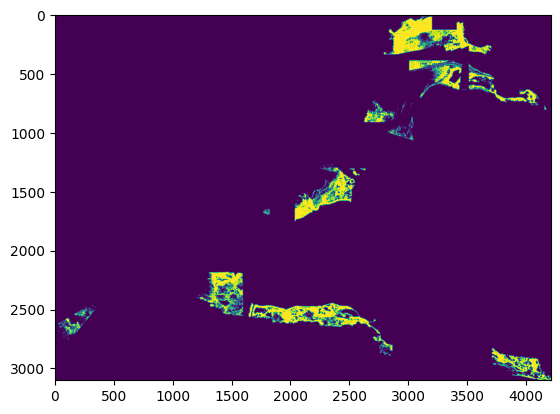

<AxesSubplot:>

In [5]:
from rasterio.plot import show
show(mmask)

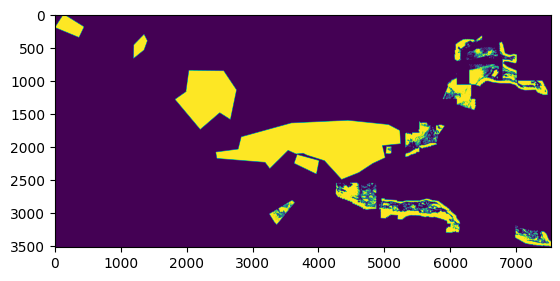

<AxesSubplot:>

In [8]:
show(nmmask)

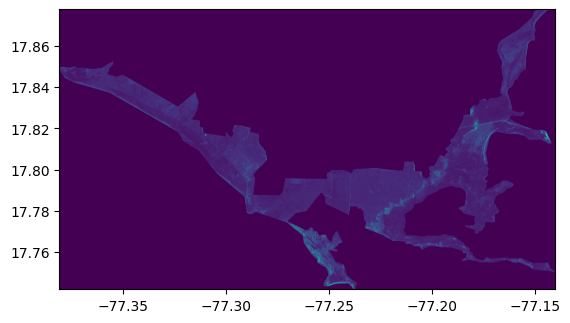

<AxesSubplot:>

In [9]:
show(src)

# Reshaping Data

In [6]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1)
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)

In [7]:
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]

m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]

In [8]:
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))

In [35]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [36]:
x_sub, y_sub = balanced_subsample(x,y,0.6)

In [37]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x_sub, y_sub, test_size=0.20, random_state=42)

# Gridsearchcv for Extremely Randomized Tree and Evaluation

In [70]:
hyperparameters = {"forest__n_jobs":[10], "forest__n_estimators":np.arange(170,260,40), "forest__max_depth":np.arange(80,250,50)}
pl = Pipeline([('forest',ExtraTreesClassifier())])
grids = GridSearchCV(pl,hyperparameters, cv=5)
grids.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest', ExtraTreesClassifier())]),
             param_grid={'forest__max_depth': array([ 80, 130, 180, 230]),
                         'forest__n_estimators': array([170, 210, 250]),
                         'forest__n_jobs': [10]})

In [71]:
grids.best_params_

{'forest__max_depth': 230, 'forest__n_estimators': 250, 'forest__n_jobs': 10}

In [72]:
op_mdl = grids.best_estimator_
y_pred = op_mdl.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     46093
         1.0       0.94      0.97      0.96     46164

    accuracy                           0.96     92257
   macro avg       0.96      0.96      0.96     92257
weighted avg       0.96      0.96      0.96     92257



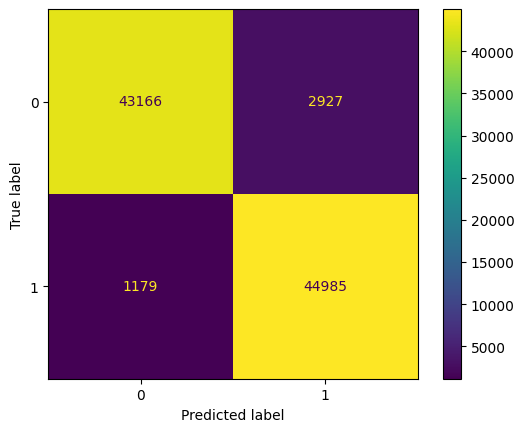

In [73]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

---

# XGboost with ray-tune

In [38]:
import sklearn.metrics
import os
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
import xgboost as xgb

from ray import air, tune
from ray.air import session
from ray.tune.integration.xgboost import TuneReportCheckpointCallback


def train_jamaica(config:dict):
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)
    # Train the classifier
    results = {}
    xgb.train(
         config,
         train_set,
         evals=[(test_set, "eval")],
         verbose_eval=False,
         callbacks=[TuneReportCheckpointCallback(filename="model.xgb")],)

def get_best_model_checkpoint(results):
    best_bst = xgb.Booster()
    best_result = results.get_best_result()
    
    with best_result.checkpoint.as_directory() as best_checkpoint_dir:
        best_bst.load_model(os.path.join(best_checkpoint_dir, "model.xgb"))
    accuracy = 1.0 - best_result.metrics["eval-error"]
    print(f"Best model parameters: {best_result.config}")
    print(f"Best model total accuracy: {accuracy:.4f}")
    return best_bst

def tune_xgboost():
    search_space = {
        # You can mix constants with search space objects.
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"],
        "max_depth": tune.randint(5, 20),
        "min_child_weight": tune.choice([3,4,5]),
        "subsample": tune.uniform(0.5, 1.0),
        "eta": tune.loguniform(1e-4, 1e-1),
    }
    # This will enable aggressive early stopping of bad trials.
    scheduler = ASHAScheduler(
        max_t=10, grace_period=1, reduction_factor=2  # 10 training iterations
    )
    
    tuner = tune.Tuner(
        train_jamaica,
        tune_config=tune.TuneConfig(
            metric="eval-logloss",
            mode="min",
            scheduler=scheduler,
            num_samples=10,
        ),
        param_space=search_space,
    )
    results = tuner.fit()

    return results


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--server-address",
        type=str,
        default=None,
        required=False,
        help="The address of server to connect to if using Ray Client.",
    )
    args, _ = parser.parse_known_args()

    if args.server_address:
        import ray

        ray.init(f"ray://{args.server_address}")

    results = tune_xgboost()

    # Load the best model checkpoint.
    best_bst = get_best_model_checkpoint(results)

2023-02-21 11:56:13,314	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (23 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-02-21 11:56:13,667	WARNING util.py:244 -- The `start_trial` operation took 0.615 s, which may be a performance bottleneck.


Trial name,date,done,episodes_total,eval-error,eval-logloss,experiment_id,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_jamaica_c94c5_00000,2023-02-21_11-56-37,True,,0.0522184,0.687065,ebbaf584732c4e9bbebfa7edf31b42c0,Runyus-MacBook-Pro.local,10,127.0.0.1,59529,20.8529,1.23994,20.8529,1677009397,0,,10,c94c5_00000,0.00282383
train_jamaica_c94c5_00001,2023-02-21_11-56-43,True,,0.0480634,0.592608,4feb30773a324a1fa3a8f1e597040e5f,Runyus-MacBook-Pro.local,10,127.0.0.1,59534,21.1153,1.52107,21.1153,1677009403,0,,10,c94c5_00001,0.00633979
train_jamaica_c94c5_00002,2023-02-21_11-56-26,True,,0.052083,0.687653,d3ac42ccb1ea42c2b5218a34ff28a2d9,Runyus-MacBook-Pro.local,1,127.0.0.1,59535,4.34782,4.34782,4.34782,1677009386,0,,1,c94c5_00002,0.0125201
train_jamaica_c94c5_00003,2023-02-21_11-56-28,True,,0.0527333,0.693041,322851725e51420fa2d14958c06f0eb4,Runyus-MacBook-Pro.local,1,127.0.0.1,59536,5.57542,5.57542,5.57542,1677009388,0,,1,c94c5_00003,0.00998282
train_jamaica_c94c5_00004,2023-02-21_11-56-32,True,,0.0513423,0.682194,149744caf2b8496bbadb5971ec125929,Runyus-MacBook-Pro.local,2,127.0.0.1,59537,9.28396,3.40378,9.28396,1677009392,0,,2,c94c5_00004,0.00814104
train_jamaica_c94c5_00005,2023-02-21_11-56-32,True,,0.0498067,0.688241,857b8d8de62e43de8cc04fa720b05a56,Runyus-MacBook-Pro.local,2,127.0.0.1,59538,9.26876,3.3727,9.26876,1677009392,0,,2,c94c5_00005,0.00465512
train_jamaica_c94c5_00006,2023-02-21_11-56-27,True,,0.052381,0.692923,c7bdd07f71d7439890f6a5297ed09fe7,Runyus-MacBook-Pro.local,1,127.0.0.1,59539,4.14549,4.14549,4.14549,1677009387,0,,1,c94c5_00006,0.0050261
train_jamaica_c94c5_00007,2023-02-21_11-56-28,True,,0.0517758,0.692546,b9ee06a828324160940001ec956929fa,Runyus-MacBook-Pro.local,1,127.0.0.1,59540,4.29264,4.29264,4.29264,1677009388,0,,1,c94c5_00007,0.00482512
train_jamaica_c94c5_00008,2023-02-21_11-56-30,True,,0.0507913,0.69258,d3ac42ccb1ea42c2b5218a34ff28a2d9,Runyus-MacBook-Pro.local,1,127.0.0.1,59535,3.95341,3.95341,3.95341,1677009390,0,,1,c94c5_00008,0.0125201
train_jamaica_c94c5_00009,2023-02-21_11-56-31,True,,0.0517036,0.692972,c7bdd07f71d7439890f6a5297ed09fe7,Runyus-MacBook-Pro.local,1,127.0.0.1,59539,3.24544,3.24544,3.24544,1677009391,0,,1,c94c5_00009,0.0050261


2023-02-21 11:56:43,365	INFO tune.py:762 -- Total run time: 33.83 seconds (33.20 seconds for the tuning loop).


Best model parameters: {'objective': 'binary:logistic', 'eval_metric': ['logloss', 'error'], 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.6275740449067377, 'eta': 0.013317685827070295}
Best model total accuracy: 0.9519


In [62]:
y_pred = best_bst.predict(xgb.DMatrix(test_x))
pred = []
for y in y_pred:
    if y<0.5:
        pred.append(0)
    else:
        pred.append(1)
pred = np.array(pred)

In [63]:
from sklearn.metrics import classification_report

print(classification_report(test_y, pred))

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     55321
         1.0       0.94      0.97      0.95     55387

    accuracy                           0.95    110708
   macro avg       0.95      0.95      0.95    110708
weighted avg       0.95      0.95      0.95    110708



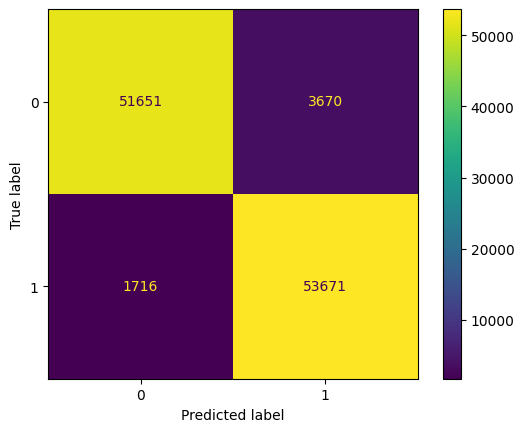

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()